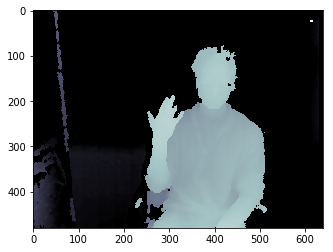

In [2]:
import matplotlib.pyplot as mpplot
from skimage import io as skimio

img_name = '/home/xwu/data/nyu_hand/test/depth_1_0000001.png'
mat_name = '/home/xwu/data/nyu_hand/test/joint_data.mat'
img_name = '/home/xwu/data/univue/palau/nyu_hand/log/super_ov3edt2m/depth_1_0002600.png'

img = skimio.imread(img_name).astype(float)
dep = (img[:, :, 1] * 256) + img[:, :, 2]
mpplot.imshow(dep, cmap=mpplot.cm.bone_r)
mpplot.show()

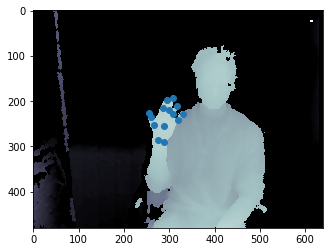

6.9699801486e-13


In [27]:
import numpy as np
import scipy.io
from collections import namedtuple

caminfo = namedtuple('caminfo', ['focal', 'centre', 'z_range', 'crop_size'])
ci = caminfo((588.036865, 587.075073), (320, 240), (100., 2060.), 128)

def d2z_to_raw(p2z, caminfo):
    """ reproject 2d poses to 3d.
        p2z: nx3 array, 2d position and real z
    """
    p2z = p2z.astype(float)
    pose2d = p2z[:, 0:2]
    pose_z = np.array(p2z[:, 2]).reshape(-1, 1)
    # pose2d = pose2d[:, ::-1]  # image coordinates: reverse x, y
    pose3d = (pose2d - caminfo.centre) / caminfo.focal * pose_z
    return np.hstack((pose3d, pose_z))

def raw_to_2dz(points3, caminfo):
    """ project 3D point onto image plane using camera info
        Args:
            points3: nx3 array, raw input in real world coordinates
    """
    points3 = points3.astype(float)
    pose_z = points3[:, 2]
    pose2d = points3[:, 0:2] / pose_z.reshape(-1, 1) * caminfo.focal + caminfo.centre
    #pose2d = pose2d[:, ::-1]  # image coordinates: reverse x, y
    return pose2d, pose_z

def raw_to_2d(points3, caminfo):
    pose2d, _ = raw_to_2dz(points3, caminfo)
    return pose2d

mat_reader = scipy.io.loadmat(mat_name)
join_keep = (0, 3, 6, 9, 12, 15, 18, 21, 24, 25, 27, 30, 31, 32)
poses = mat_reader['joint_xyz'][0, 2600, join_keep, :]
#print(poses)
poses[:, 1] *= -1
pose2d, pose_z = raw_to_2dz(poses, ci)
#print(pose2d)
mpplot.imshow(dep, cmap=mpplot.cm.bone_r)
mpplot.plot(pose2d[:, 0], pose2d[:, 1], 'o')
mpplot.show()
uvd = np.hstack((
    pose2d,
    pose_z.reshape(-1, 1))
)
poses_rep = d2z_to_raw(uvd, ci)
print(np.sum(np.abs(poses - poses_rep)))

(2001.0, 855.0)


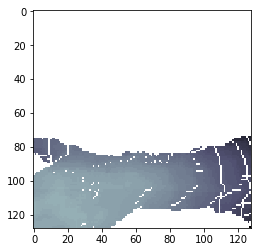

In [29]:
import sys
sys.path.append('/home/xwu/projects/univue-hand-pose/code/utils')
from iso_boxes import iso_cube

def img_to_raw(img, caminfo, crop_lim=None):
    conds = np.logical_and(
        caminfo.z_range[1] > img,
        caminfo.z_range[0] < img
    )
    indx = np.where(conds)
    zval = np.array(img[conds])
    indz = np.vstack((
        np.asarray(indx).astype(float),
        zval
    )).T
    points3 = d2z_to_raw(indz, caminfo)
    if crop_lim is not None:
        conds = np.logical_and.reduce([
            -crop_lim < points3[:, 0], crop_lim > points3[:, 0],
            -crop_lim < points3[:, 1], crop_lim > points3[:, 1],
        ])
        return points3[conds, :]
    else:
        return points3

def to_clean(img, cube, caminfo, sort=False):
    # mpplot.imshow(img, cmap=mpplot.cm.bone_r)
    # mpplot.show()
    points3_pick = cube.pick(img_to_raw(img, caminfo))
    print(np.max(img), np.min(img))
    coord, depth = cube.raw_to_unit(points3_pick, sort=sort)
    img_clean = cube.print_image(
        coord, depth, caminfo.crop_size)
    # mpplot.imshow(img_clean, cmap=mpplot.cm.bone_r)
    # mpplot.show()
    return img_clean

cube = iso_cube(
    (np.max(poses, axis=0) + np.min(poses, axis=0)) / 2,
    120
)
img_clean = to_clean(dep, cube, ci)
mpplot.imshow(img_clean, cmap=mpplot.cm.bone_r)